## Imports

In [5]:
import pandas as pd
from statsmodels.stats import multitest
import matplotlib.pyplot as plt
import pandas as pd
#from timers import *
import warnings
from pingouin import rcorr
from copy import deepcopy
import seaborn as sns
from functions_and_classes import *
warnings.filterwarnings("ignore")

print("Done")

Done


## Prepare dataframe

Processing Broodminder weather data.
Reading Broodminder weather data.
Processing Ambient data.
Processing Broodminder data.
Reading Broodminder data.
Done


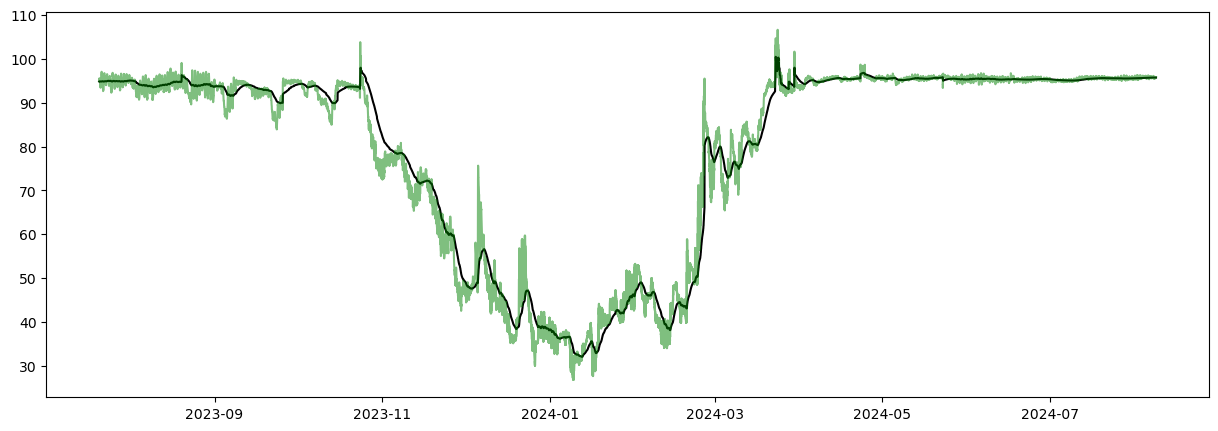

In [2]:
hive_IDs = {"New Left Hive": '6b5cb8b012cb45038eacc24770a2fff7',
            "Utah OW Nuc Left": '13a71f80590a4184a2956058441c3be3',
            "Utah OW Nuc Right": 'dca02aae55b74ca1b1a6ac35042d2254',
           }

Bee_Weather = BeeWeather()
Bee_Weather.set()

ambient = Ambient()
ambient.set()

master_df = pd.DataFrame()

# for hive_creds in list(hive_IDs.items()):
# current_hive = Hive(*hive_creds)
current_hive = Hive(*list(hive_IDs.items())[0])
current_hive.set()
master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_weight(remove_outliers = 1)).rename(columns={"Weight": "hive_weight"})], axis = 1)
if not current_hive.get_upper_temp().empty:
    master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_upper_temp(remove_outliers = 1)).rename(columns={"Temperature": "hive_upper_temp"})], axis = 1)
if not current_hive.get_lower_temp().empty:
    master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_lower_temp(remove_outliers = 1)).rename(columns={"Temperature": "hive_lower_temp"})], axis = 1)
if not current_hive.get_humidity().empty:
    master_df = pd.concat([master_df, pd.DataFrame(current_hive.get_humidity(remove_outliers = 1)).rename(columns={"Humidity": "hive_humidity"})], axis = 1)

master_df = pd.concat([master_df, Bee_Weather.get_beeweather(), ambient.get_ambient()], axis = 1)
try:
    master_df.dropna(subset=['hive_weight', 'hive_upper_temp', 'hive_lower_temp', 'hive_humidity'], axis = "rows", how = "all", inplace = True)
except Exception as e:
    print(e)

try:
    master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_weight'].dropna().index, "kalman_weight": kalman(master_df['hive_weight'].dropna())}).set_index("Unix_Time")], axis = 1)
except Exception as e:
    print(e)
    
master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_upper_temp'].dropna().index, "kalman_upper_temp": kalman(master_df['hive_upper_temp'].dropna())}).set_index("Unix_Time")], axis = 1)
master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_lower_temp'].dropna().index, "kalman_lower_temp": kalman(master_df['hive_lower_temp'].dropna())}).set_index("Unix_Time")], axis = 1)
master_df = pd.concat([master_df, pd.DataFrame({'Unix_Time': master_df['hive_humidity'].dropna().index, "kalman_humidity": kalman(master_df['hive_humidity'].dropna())}).set_index("Unix_Time")], axis = 1)

fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(master_df['hive_lower_temp'].dropna().index,  master_df['kalman_lower_temp'].dropna(), color="black")
ax.plot(master_df['hive_lower_temp'].dropna().index,  master_df['hive_lower_temp'].dropna(), alpha = 0.5, color="green")
#ax.plot(pd.DataFrame(current_hive.get_lower_temp()).dropna().index,  pd.DataFrame(current_hive.get_lower_temp()).dropna(), alpha = 0.3)

print("Done")

## Create correlation matrix

In [3]:
master_df2 = deepcopy(master_df)

master_df2.drop(columns = ['lastRain', 'Temperature', 'eventrainin', 'monthlyrainin', 'weeklyrainin', 'totalrainin', 'yearlyrainin', 'Relative_Humidity', 'Precipitation_inches', 'winddir', 'maxdailygust', 'uv'], inplace = True)

#correlation matrix
matrix = master_df2.rcorr(padjust = 'bonf')
matrix = matrix.replace('-','1.0')

print("Done")

Done


## Display correlation matrix

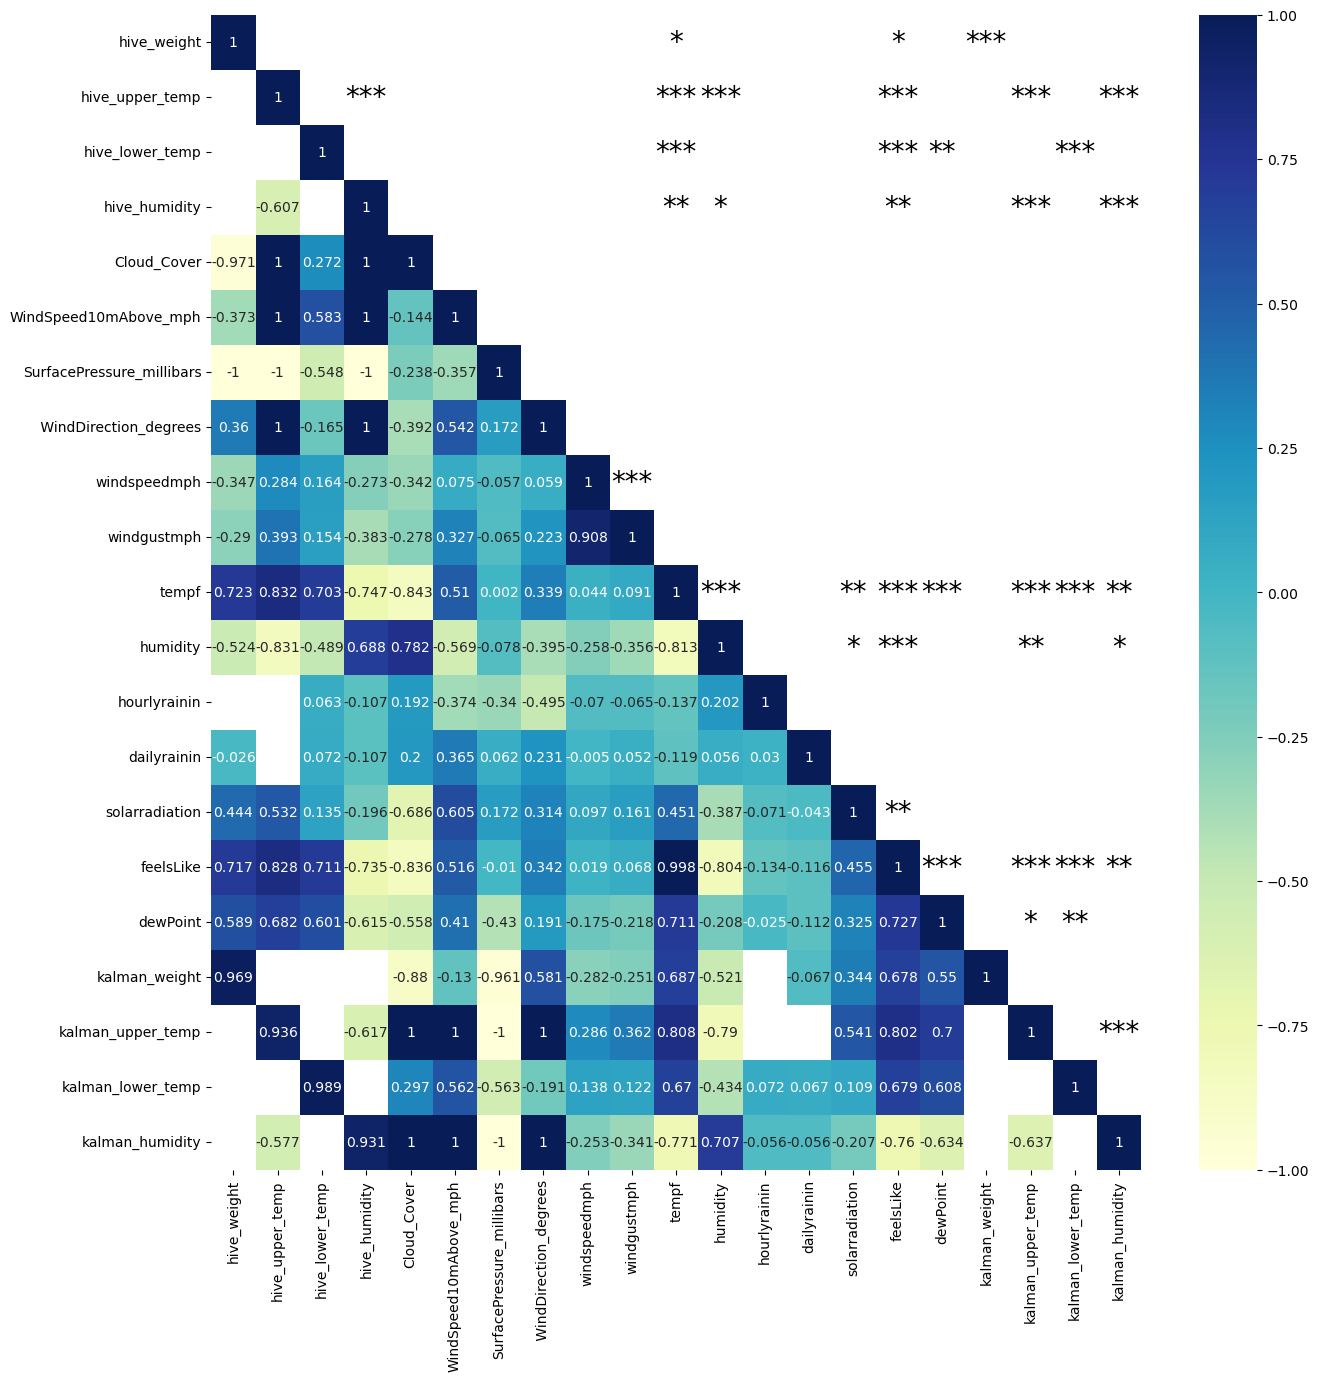

In [4]:
# create mask (see source below in answer)
mask = np.zeros_like(matrix, dtype=bool)
mask[np.tril_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 15))
# apply mask, and set type to float
ax = sns.heatmap(matrix.where(mask).astype(float), 
                 annot=True, fmt="g", cmap='YlGnBu')

# invert mask for the labels ('***' vals)
labels = matrix.where(~mask).to_numpy()

# add individual labels using `ax.text` (see source below in answer)
for (j,i), label in np.ndenumerate(labels):
    if isinstance(label,str):
        ax.text(i+0.5, j+0.5, label, 
                fontdict=dict(ha='center',  va='center',
                                         color='black', fontsize=20))
plt.savefig("BonCorrMatrix")
plt.show()